To DO: 
- Consider lemmatizing using Stanford lemmatizer
- Understand how to get 'Satoshi Words' in an unbiased manner
- Methodology: reduce to list of descriminiating words. 
- See if can get good chisq p-vals (perhaps chisq is biased on this set)


In [1]:
%load_ext autoreload
import os
import re
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('/Users/kipnisal/Documents/Authorship/')

from AuthAttLib import *
from visualize_HC_scores import *

import pickle

from load_data import *
from text_processing import html_to_text
from utils import frequent_words_tfidf

<H2> Preprocess Data</H2>
<ul>
<li> Read all articles from Data directory
<li> Run only if added more articles
<li> Otherwise use pre-processed version 'data_proc.csv'
</ul>

In [21]:
# optional: remove proper names, cardinal digits, and punctuation
from text_processing import remove_parts_of_speach

def text_proc_loc(text) :
    return remove_parts_of_speach(text, to_remove = ['NNP', 'NNPS', 'CD', 'FW',
                                                    #'NN', 'NNS', 
                                                    ])

def lemmatize_list(list_of_words) :
    ls = remove_parts_of_speach(" ".join(list_of_words), to_remove=[]).split()
    return pd.DataFrame(ls).drop_duplicates().iloc[:,0].tolist()

def remove_digits(text) :
    return re.sub("[0-9]", "", text)

def remove_punct(text) :
    punct = [':',';','"','(',')','-',',','.','`','\`','%','&','?','!']
    return re.sub("[0-9]", " ", text)


In [48]:
data_proc = load_data("../Data/")
    
data_proc.text = data_proc.text.astype(str).apply(text_proc_loc).apply(cleanhtml)
data_proc.to_csv('../Data/data_proc.csv')

100%|██████████| 23/23 [01:55<00:00,  7.17s/it]


<H2>Arrange Data</H2>

In [49]:
INCLUDE_TECHNICAL = False
#arrange Staoshi's documents by topics
data_proc = pd.read_csv('../Data/data_proc.csv')

data_proc = data_proc[data_proc['type'].isin(['academic', 'book'])]

# aggreagte emails and technical forum posts
satoshi_emails = data_proc[(data_proc.author == 'Satoshi') # merge all Staoshi's emails
                         & (data_proc['type'] == 'email')].text.astype(str).agg(sum)
satoshi_forum = data_proc[(data_proc.author == 'Satoshi') # merge all Staoshi's forum posts
                          & (data_proc['type'] == 'technical (forum)')].text.astype(str).agg(sum)

data_proc = data_proc[~((data_proc.author == 'Satoshi') # merge all Staoshi's forum posts
                          & data_proc['type'].isin(['technical (forum)', 'email']))]

if INCLUDE_TECHNICAL :
    data_proc = data_proc.append({'doc_id' : 'Satoshi_emails',
                    'text' : satoshi_emails,
                    'author' : 'Satoshi',
                    'type' : 'emails'}, ignore_index = True)
    data_proc = data_proc.append({'doc_id' : 'Satoshi_forum',
                    'text' : satoshi_forum,
                    'author' : 'Satoshi',
                    'type' : 'technical (forum)'},ignore_index = True)

<H2>Using preset Dictionaries</H2>

In [50]:
function_words1 =  ['a','as','do','has','is','no','or','than','this','when',
  'all','at','down','have','it','not','our','that','to','which',
  'also','be','even','her','its','now','shall','the','up','who',
  'an','been','every','his','may','of','should','their','upon','will',
  'and','but','for','if','more','on','so','then','was','with',
  'any','by','from','in','must','one','some','there','were','would',
  'are','can','had','into','my','only','such','thing','what','your', ]

# two list of additional words used by Mosteller & Wallace
additional_words1 = ['affect','city','direction','innovation','perhaps','vigor',
                    'again','commonly','disgracing','join','rapid','violate','although',
                    'consequently','either','language','sarne','violence','among','considerable',
                     'consider', 'enough','most','second','voice','another','contribute','nor','still',
                    'where','because','defensive','fortune','offensive','those','whether',
                    'between','destruction','often','throughout', 'while','both','provide', 
                    'did','himself','pass','under','whilst', 'preclude', 'note', 'additional', 'reveal']

additional_words2 = ['about','choice','proper','according','common','kind','propriety','adversaries',
                    'danger','large','provision','after','decide','decides','decided','deciding',
                    'likely','requiisite','aid','degree','matters','matter','substance','always',
                    'during','moreover','they','apt','expence','necessary','though',
                    'asserted','expenses','expense','necessity','necessities','truth','truths',
                    'before','extent','others','us','being','follows','follow','particularly',
                    'usages','usage','better','I','principle','we','care','imagine','edit','editing']

web_words = ['https', 'typekit','subset_id','cid', 'fvd','af', 'opentype','woff','tk', 'http',
             'sinc','www','site','mso','com','af','font','src','url','proxima','color','microsoft',
             'body', 'sans','%','ded','fb', 'php',' ', 'badb','fdb','fa', 'table', 'nav', 'linux',
             'div', 'saved', 'unix', 'text', 'xi', 'ad', 'pp', 'a', 'px', 'db', 'var','re', 'environment',
             'width', 'height', 'align', 'left', 'rel', 'nofollow', 'rel','viewbox', 'version', 'path', 
             'fill','radius', 'noopener', 'noreferrer', 'image', 'file', 'truncate', 'target', '_blank',
             'nova', 'border', 'st1' ,'vwh', 'item', 'link', 'border', 'left',
             'img', 'normal', 'edge', 'lh', 'style', 'family', 'content', 'castronova', 'buttonize','net',
             'th','kudo','activate','figure', 'pro','tree', 'user','disk','href', 'quot', 'org', 'meta',
             'js', 'doe', 'online', 'address', 'click', 'aria', 'line', 'title', 'css', 'nbsp', 'yes',
            'br', 'flex', 'script', 'td', 'ninja', 'wp', 'letter', 'password', 'span','class','li','lib',
             'le', 'face', 'format', 'weight', 'web', 'en', 'est', 'co', 'function','don', 'hr', 
            'que', 'tu', 'ça', 'au', 'ai', 've', 'te', 'si', 'ca', 'sa'
            ]

             
names = ['hal', 'san','craig','wright','satoshi','vili','lehdonvirta',
        'bick', 'szabo', 'kleiman', 'gavinandresen', 'gavin', 'andresen', 'adi',
        'shamir', 'david', 'claude', 'shannon', 'elon', 'musk', 'thomas', 'meyer',
         'einstein'
        ]
               
jargon = ['bitcoin', 'homomorphic', 'pornography', 'syngress', 'fingerprint', 'chapter',
          'forensic', 'forensic', 'cryptographic', 'address', 'ciphertext',
          'compromised', 'contractual', 'polynomial', 'investigative', 'electronic', 'double',
          'public', 'verify', 'trusted','generate', 'honest', 'github', 'bitcoinxt', 'computer',
         'digital', 'control', 'work', 'private', 'virtual', 'key'
         ] 

punct = [':',';','"','(',')','-',',','.','`','\`','%','&','?','!']

function_words = lemmatize_list(function_words1 + additional_words1 + additional_words2)

Satoshi_function_words = ['or', 'this', 'it', 'to', 'the', 'up', 'his', 'may', 'of', 'and',
        'if', 'by', 'in', 'one', 'were', 'would', 'enough', 'still',
        'while', 'himself', 'after', 'they', 'before', 'care', 'work']

Satoshi_words = ['to', 'and', 'in', 'it', 'or', 'by', 'you', 'each', 'new', 'need',
        'he', 'them', 'need to', 'without', 'the ha', 'after', 'long',
        'still', 'work', 'next', 'get', 'in it', 'to make', 'it to',
        'back', 'previous', 'until', 'the next', 'enough', 'change',
        'added', 'working', 'the previous', 'control', 'ever', 'to get',
        'accepted', 'accept', 'page', 'receive', 'containing', 'they were']

In [25]:
#load preset vocabulary
from text_processing import *
vocab5000_df = pd.read_csv('~/Data/5000 most common english words.csv')
vocab5000 = lemmatize_list(vocab5000_df.Word) # to remove dublicate terms

vocab_tfidf = list(frequent_words_tfidf(data_proc.text, ngram_range = (1,3),
                                   no_words= 1500,
                                   words_to_ignore = punct + web_words + names + punct + jargon
                                  ))


In [51]:
#train model

ds = data_proc
ds = ds[~ds['type'].isin(['technical (forum)','email'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]
ds = ds.filter(['doc_id','text','author','type'])

ds = ds.dropna()

VOCAB_SIZE = 1500
NG_RANGE = (1,3)

model = AuthorshipAttributionMulti(ds,
                               vocab = function_words,
                              #vocab_size = VOCAB_SIZE,
                              ngram_range = NG_RANGE,
                            words_to_ignore = punct + web_words + names + punct + jargon,
                              stbl = True,
                                  flat=True)
vocab_size = len(model._vocab)
#desc = "external_data"

# get results wrt Satoshi:
df0 = model.internal_stats_corpus()
df_satoshi = df0[(df0.author == 'Satoshi') | (df0.wrt_author == 'Satoshi')]
df_satoshi.loc[df_satoshi.author == 'Satoshi', 'author'] = df_satoshi.loc[df_satoshi.author == 'Satoshi','wrt_author']
df_satoshi.loc[:,'wrt_author'] = 'Satoshi'

	 Creating author-model for Dan Boneh using 171 features...
		found 4 documents and 5847 relevant tokens.
	 Creating author-model for Adam Back using 171 features...
		found 2 documents and 1169 relevant tokens.
	 Creating author-model for Wright-Kleiman using 171 features...
		found 1 documents and 2413 relevant tokens.
	 Creating author-model for Vili Lehdonvirta using 171 features...
		found 8 documents and 41663 relevant tokens.
	 Creating author-model for Crypto Collection using 171 features...
		found 3 documents and 10145 relevant tokens.
	 Creating author-model for Satoshi using 171 features...
		found 1 documents and 1421 relevant tokens.
	 Creating author-model for Michael Clear using 171 features...
		found 1 documents and 13613 relevant tokens.
	 Creating author-model for Nick Szabo using 171 features...
		found 5 documents and 12235 relevant tokens.
	 Creating author-model for Claude Shannon using 171 features...
		found 2 documents and 20038 relevant tokens.
	 Creating au

  0%|          | 0/14 [00:00<?, ?it/s]

		found 1 documents and 101223 relevant tokens.
	 Creating author-model for Albert Einstein using 171 features...
		found 4 documents and 23067 relevant tokens.


 14%|█▍        | 2/14 [00:01<00:09,  1.22it/s]/Users/kipnisal/Documents/Authorship/utils.py:34: RuntimeWarning: divide by zero encountered in log
  return chisq - dof, np.log(pval)
100%|██████████| 14/14 [00:07<00:00,  1.61it/s]
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
description = "w{}_most_common_ng_remove_NN_web_remove".format(len(model._vocab))
description = "w{}_tfidf_ng".format(len(model._vocab))
description = "function_words"

In [53]:
df0 = model.internal_stats_corpus()
df_satoshi = df0[(df0.author == 'Satoshi') | (df0.wrt_author == 'Satoshi')]
df_satoshi.loc[df_satoshi.author == 'Satoshi', 'author'] =\
                df_satoshi.loc[df_satoshi.author == 'Satoshi','wrt_author']
df_satoshi.loc[:,'wrt_author'] = 'Satoshi'

df_satoshi.loc[df_satoshi.HC.sort_values().index,:]

100%|██████████| 14/14 [00:07<00:00,  1.45it/s]


,HC,HC_rank,author,chisq,chisq_pval,cosine,feat,no_docs (author),no_docs (wrt_author),no_tokens (author),wrt_author
71,3.673909,0.5,David Mazieres,186.272322,-38.578213,0.027792,"[a, or, our, to, which, be, the, up, his, may,...",1.0,1.0,1421.0,Satoshi
11,3.856491,0.5,Adam Back,125.370119,-25.186319,0.028950,"[is, all, it, our, that, to, which, up, every,...",1.0,1.0,1421.0,Satoshi
84,4.422782,0.5,Albert Einstein,411.797389,-113.392309,0.051400,"[a, than, this, it, to, which, be, up, an, of,...",1.0,1.0,1421.0,Satoshi
64,4.585410,0.5,Craig Wright,270.223584,-66.463472,0.019627,"[or, this, it, that, up, every, his, but, if, ...",1.0,1.0,1421.0,Satoshi
29,4.600586,0.5,Wright-Kleiman,204.063695,-48.092436,0.034275,"[a, is, or, this, it, our, that, to, be, even,...",1.0,1.0,2413.0,Satoshi
76,4.761433,0.5,David Kleiman,409.621384,-108.697708,0.029463,"[a, or, than, this, it, not, our, to, also, th...",1.0,1.0,1421.0,Satoshi
37,4.899704,0.5,Nick Szabo,243.199247,-55.495629,0.030219,"[a, or, this, all, it, to, which, the, up, an,...",1.0,1.0,1421.0,Satoshi
30,5.092812,0.5,Vili Lehdonvirta,477.711933,-136.079644,0.050808,"[or, this, all, it, to, also, be, the, up, eve...",1.0,1.0,41663.0,Satoshi
42,5.253215,0.5,Claude Shannon,474.777985,-143.310226,0.040412,"[do, is, this, it, to, which, up, who, an, eve...",1.0,1.0,1421.0,Satoshi
2,5.297894,0.5,Dan Boneh,230.701941,-54.638281,0.027068,"[is, this, it, our, that, to, up, every, his, ...",1.0,1.0,1421.0,Satoshi


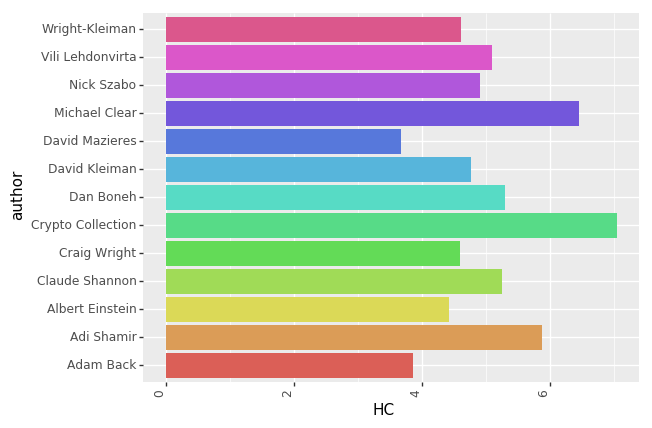

<ggplot: (313792937)>


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 13 x 4 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: HC_wrt_satoshi_function_words.png
  warn('Filename: {}'.format(filename))


In [54]:
from plotnine import *
import matplotlib.colors as mcolors

path_to_figs = "/Users/kipnisal/Dropbox/Apps/Overleaf/Who is Satoshi/Figs/"
path_to_figs = ""

ix = df_satoshi.reset_index().sort_values('HC').index.tolist()

p = (ggplot(aes(x = 'author', y = 'HC', fill = 'author'), data = df_satoshi) 
     + geom_col(show_legend = False) + theme(axis_text_x=element_text(rotation=90, hjust=1)) 
  #  + scale_x_discrete(limits=ix)
     + coord_flip()
    )
print(p)
p.save(path_to_figs + "HC_wrt_satoshi_{}.png".format(description),height = 4, width = 13)


<H3>Load all data (including hidden files)</H3>

In [ ]:
# get most freuqnect words from all data
all_data = load_data("../Data/", ignore_prefix = '')
all_data_proc = all_data.copy()

all_data_proc.loc[:,'text'] = all_data.text.astype(str).apply(text_proc_loc).apply(cleanhtml)

vocab_all = n_most_frequent_words(all_data.text, n = 3000, ngram_range=(2,3),
        words_to_ignore=punct + web_words + jargon
                      )

<H2>Model with some features removed</H2>

In [30]:
btc_paper = data_proc[data_proc.doc_id == 'Bitcoin_whitepaper.txt']
#df_feat = model.get_discriminating_features(btc_paper.text.values[0])
df_feat = model.test_against(btc_paper.text.values[0])

100%|██████████| 14/14 [00:04<00:00,  2.55it/s]


In [31]:
dfeat = df_feat[~df_feat.z.isna()].feat
dfeat.tolist()

['or',
 'this',
 'it',
 'to',
 'up',
 'his',
 'and',
 'by',
 'in',
 'one',
 'would',
 'enough',
 'still',
 'himself',
 'after',
 'they']

In [32]:
new_vocab = [w for w in model._vocab if w not in dfeat.tolist()]
print("removed {} features".format(len(model._vocab) - len(new_vocab)))

removed 16 features


In [33]:
#train model

ds = data_proc
ds = ds[~ds['type'].isin(['technical (forum)','email'])]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]
ds = ds.filter(['doc_id','text','author','type'])

ds = ds.dropna()

model = AuthorshipAttributionMulti(ds,
                               vocab = new_vocab,
                              ngram_range = NG_RANGE,
                              stbl = True)
vocab_size = len(model._vocab)
#desc = "external_data"

# get results wrt Satoshi:
df0 = model.internal_stats_corpus()
df_satoshi = df0[(df0.author == 'Satoshi') | (df0.wrt_author == 'Satoshi')]
df_satoshi.loc[df_satoshi.author == 'Satoshi', 'author'] = df_satoshi.loc[df_satoshi.author == 'Satoshi','wrt_author']
df_satoshi.loc[:,'wrt_author'] = 'Satoshi'

	 Creating author-model for Dan Boneh using 155 features...
		found 4 documents and 4476 relevant tokens.
	 Creating author-model for Adam Back using 155 features...
		found 1 documents and 104 relevant tokens.
	 Creating author-model for Wright-Kleiman using 155 features...
		found 1 documents and 1915 relevant tokens.
	 Creating author-model for Vili Lehdonvirta using 155 features...
		found 8 documents and 30289 relevant tokens.
	 Creating author-model for Crypto Collection using 155 features...
		found 3 documents and 7876 relevant tokens.
	 Creating author-model for Satoshi using 155 features...
		found 1 documents and 1046 relevant tokens.
	 Creating author-model for Michael Clear using 155 features...
		found 1 documents and 10835 relevant tokens.
	 Creating author-model for Nick Szabo using 155 features...
		found 5 documents and 9088 relevant tokens.
	 Creating author-model for Claude Shannon using 155 features...
		found 2 documents and 15900 relevant tokens.
	 Creating autho

  0%|          | 0/14 [00:00<?, ?it/s]

		found 4 documents and 18058 relevant tokens.


 14%|█▍        | 2/14 [00:02<00:11,  1.05it/s]/Users/kipnisal/Documents/Authorship/utils.py:34: RuntimeWarning: divide by zero encountered in log
  return chisq - dof, np.log(pval)
100%|██████████| 14/14 [00:09<00:00,  1.04it/s]
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [89]:
df0 = model.internal_stats_corpus()
df_satoshi = df0[(df0.author == 'Satoshi') | (df0.wrt_author == 'Satoshi')]
df_satoshi.loc[df_satoshi.author == 'Satoshi', 'author'] =\
                df_satoshi.loc[df_satoshi.author == 'Satoshi','wrt_author']
df_satoshi.loc[:,'wrt_author'] = 'Satoshi'


100%|██████████| 18/18 [01:23<00:00,  7.44s/it]


In [90]:
description = "w{}_most_common_ng_remove_NN_web_remove_Satoshi_words".format(len(model._vocab))
description = "w{}_tfidf_ng_remove_Satoshi_words".format(len(model._vocab))
#description = "function_words_remove_Satoshi_words"

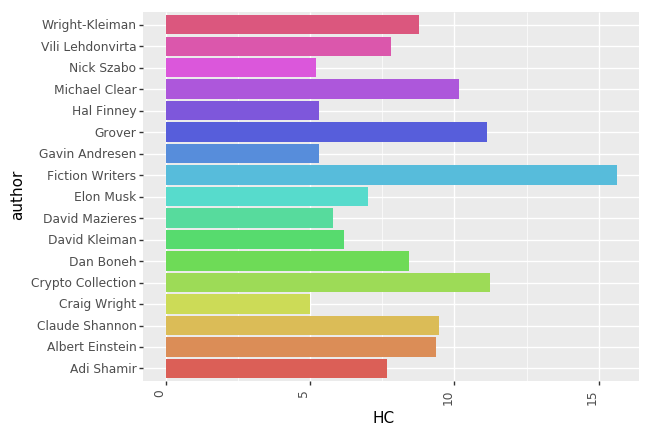

<ggplot: (313985719)>


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 13 x 4 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /Users/kipnisal/Dropbox/Apps/Overleaf/Who is Satoshi/Figs/HC_wrt_satoshi_w1424_tfidf_ng_remove_Satoshi_words.png
  warn('Filename: {}'.format(filename))


In [91]:
from plotnine import *
import matplotlib.colors as mcolors

path_to_figs = "/Users/kipnisal/Dropbox/Apps/Overleaf/Who is Satoshi/Figs/"

ix = df_satoshi.reset_index().sort_values('HC').index.tolist()

p = (ggplot(aes(x = 'author', y = 'HC', fill = 'author'), data = df_satoshi) 
     + geom_col(show_legend = False) + theme(axis_text_x=element_text(rotation=90, hjust=1)) 
  #  + scale_x_discrete(limits=ix)
     + coord_flip()
    )
print(p)
p.save(path_to_figs + "HC_wrt_satoshi_{}.png".format(description),height = 4, width = 13)


<H2>Finalists</H2>

In [33]:
#scores wrt Satoshi
finalists = ('Craig Wright', 'Nick Szabo', 'Hal Finney')
df = model.internal_stats(wrt_authors=finalists, LOO = False)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: seems like all counts are zero. Did you pass the wrong data format?

In [ ]:
wrt_authors = ['Craig Wright', 'Nick Szabo']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)
p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)

In [ ]:
wrt_authors = ['Craig Wright', 'Hal Finney']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)
p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)

In [20]:
wrt_authors = ['Hal Finney', 'Nick Szabo']
p = plot_author_pair(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)

p = plot_LDA(df[df.author.isin(wrt_authors + ['Satoshi'])], value = 'HC',  wrt_authors = wrt_authors)
print(p)

NameError: name 'df' is not defined

In [116]:
# TODO: only use list of finalists
finalists = ('Nick Szabo', 'Hal Finney', 'Craig Wright', 'David Kleiman')
ds = data_proc
ds = ds[~ds['type'].isin(['technical','email'])][ds.author.isin(finalists)]
#ds = ds[~((ds.author == 'Satoshi') & (ds.type.isin(['emails', 'technical (forum)'])))]

model_binary = AuthorshipAttributionMultiBinary(ds,
                                vocab = model._vocab,
                                ngram_range=(2,3),
                                reduce_features=True
                                        )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Found 6 author-pairs
MultiBinaryAuthorModel: Creating model for Hal Finney vs Nick Szabo...
	 Creating author-model for Hal Finney using 1000 features...
		found 13 documents and 2001 relevant tokens.
	 Creating author-model for Nick Szabo using 1000 features...
		found 28 documents and 17716 relevant tokens.
Changing vocabulary for Hal Finney. Found 640 relevant tokens.
Changing vocabulary for Nick Szabo. Found 3660 relevant tokens.
Reduced to 78 features...
MultiBinaryAuthorModel: Creating model for Craig Wright vs Hal Finney...
	 Creating author-model for Hal Finney using 1000 features...
		found 13 documents and 2001 relevant tokens.
	 Creating author-model for Craig Wright using 1000 features...
		found 23 documents and 11739 relevant tokens.
Changing vocabulary for Hal Finney. Found 457 relevant tokens.
Changing vocabulary for Craig Wright. Found 1637 relevant tokens.
Reduced to 74 features...
MultiBinaryAuthorModel: Creating model for Craig Wright vs Nick Szabo...
	 Creating aut

In [104]:
btc_paper = data_proc[data_proc.doc_id == 'Bitcoin_whitepaper.txt']

In [121]:
# illustrate one pair
pair = ('Craig Wright','Hal Finney')
md = model_binary._AuthorPairModel[pair]
df = md.internal_stats()
df1 = md.predict_stats(btc_paper.text.values[0])
df1.loc[:,'doc_id'] = 'Bitcoin_whitepaper.txt'
df1.loc[:,'author'] = 'Satoshi'
df_all = df.filter(['HC', 'HC_rank','author', 'chisq', 'chisq_pval', 'doc_id', 'wrt_author']).append(df1)



  0%|          | 0/2 [00:00<?, ?it/s]

ValueError: seems like all counts are zero. Did you pass the wrong data format?

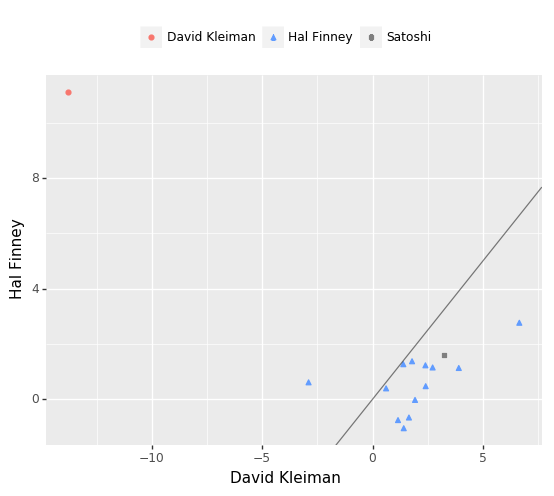

<ggplot: (315791238)>


/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/usr/local/lib/python3.7/site-packages/plotnine/stats/stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)
/usr/local/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning

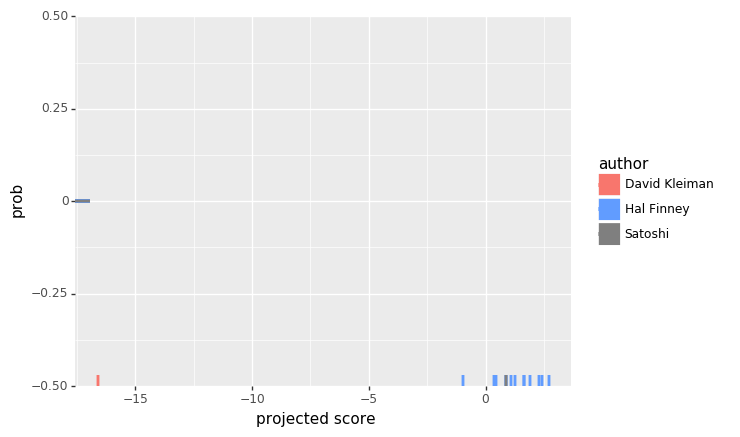

<ggplot: (-9223372036549233639)>


In [45]:
p = plot_author_pair(df_all[df_all.author.isin(list(pair) + ['Satoshi'])], value = 'HC',  wrt_authors = pair)
print(p)

p = plot_LDA(df_all[df_all.author.isin(list(pair) + ['Satoshi'])], value = 'HC',  wrt_authors = pair)
print(p)

/usr/local/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


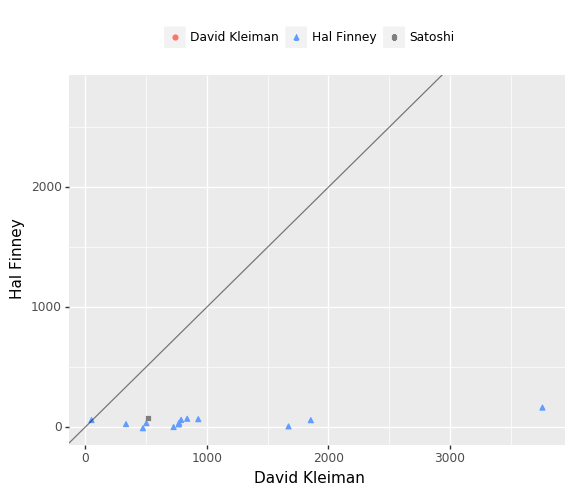

<ggplot: (314942619)>


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [46]:
p = plot_author_pair(df_all[df_all.author.isin(list(pair) + ['Satoshi'])], value = 'chisq',  wrt_authors = pair)
print(p)

p = plot_LDA(df_all[df_all.author.isin(list(pair) + ['Satoshi'])], value = 'chisq',  wrt_authors = pair)
print(p)